In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
tropopauses = {'mls': 40, 'saw': 45, 'trp': 37}
    
ilevels = [0, tropopauses[PARAM['atmpro']], -1]


In [11]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=ilevels)

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=ilevels)


In [12]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=ilevels)

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=ilevels)

In [13]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [14]:
def save_fluxcoolr_excel():
    
    fname = 'lblnew-bestfit_flux.xlsx'
    writer = pd.ExcelWriter(fname)
    
    ds = analysis.models['crd'].data['flux']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'crd flux g={int(g)}')
        
    ds = analysis.models['wgt_igg1'].data['flux']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'wgt igg=1 flux g={int(g)}')
    
    ds = analysis.models['wgt_igg10'].data['flux']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'wgt igg=10 flux g={int(g)}')
    
    writer.save()
        
    html_download = f'Download: <a href="./{fname}">{fname}</a>'
    
    display.display(display.HTML(html_download))
        
    
    



In [15]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3b
commitnumber = a22ab94
conc = 0.0008
dv = 0.001
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 257
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0, 0.6, 0.5, 0.7, 0.8), (0.8, 0.7)]


In [16]:
save_fluxcoolr_excel()

In [17]:
fig.display_hrefanchor()

In [18]:
table_fluxg.display_hrefanchor()
#table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
#table_coolr.display_hrefanchor()

In [19]:
table_dgdgs.display_hrefanchor()

In [20]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [21]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [22]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

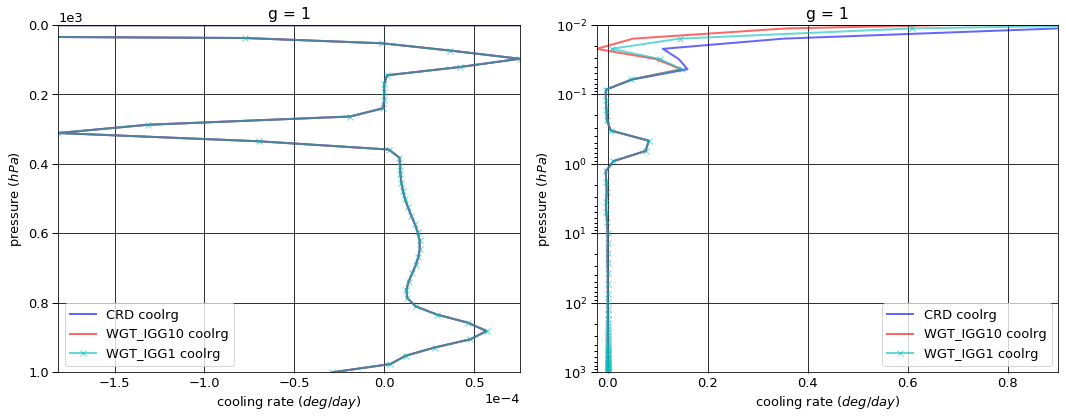

# Figure: cooling rate g-group 2

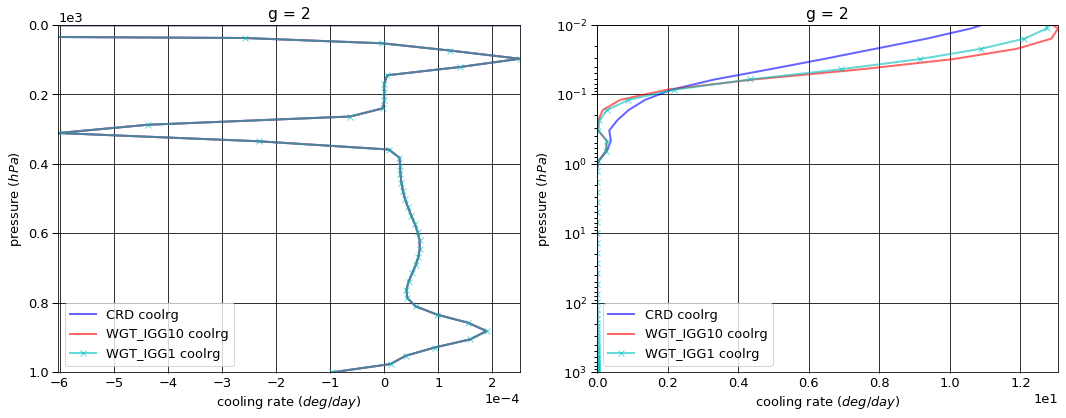

# Figure: cooling rate g-group 3

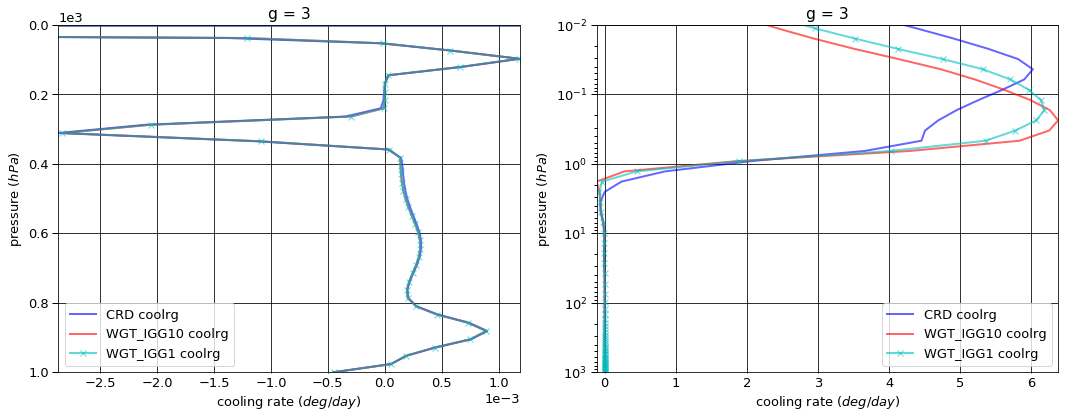

# Figure: cooling rate g-group 4

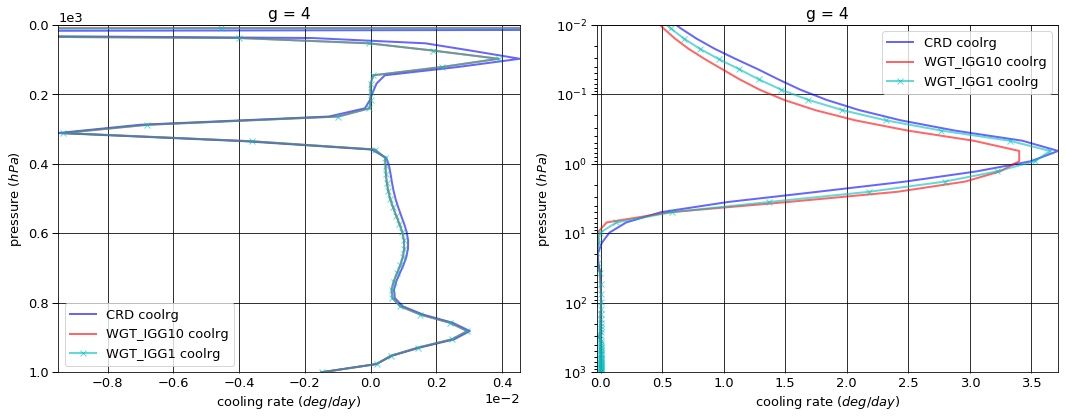

# Figure: cooling rate g-group 5

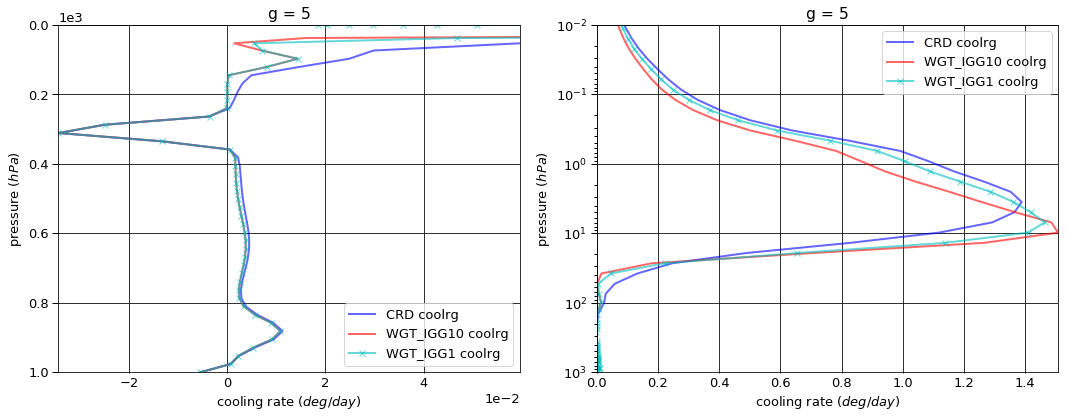

# Figure: cooling rate g-group 6

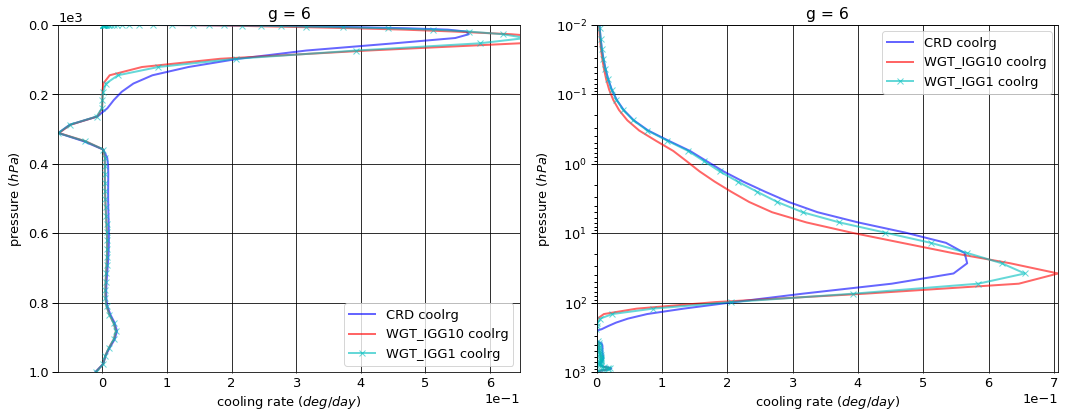

# Figure: cooling rate g-group 7

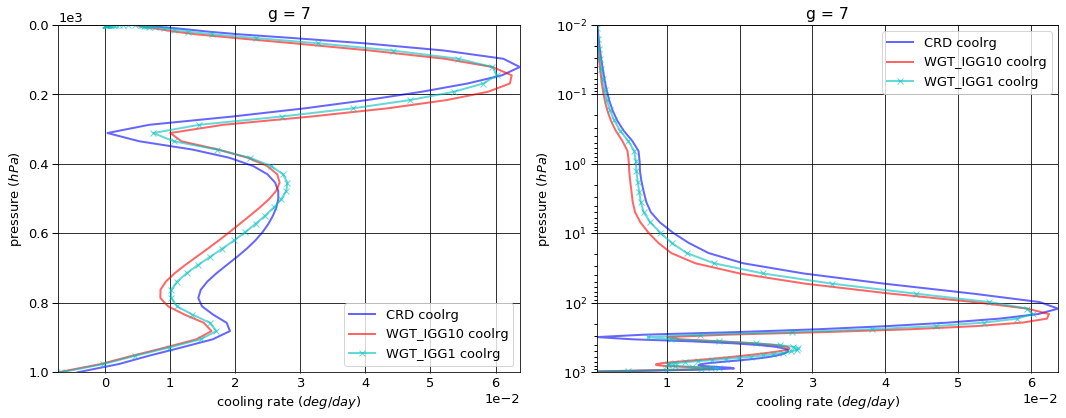

# Figure: cooling rate g-group total

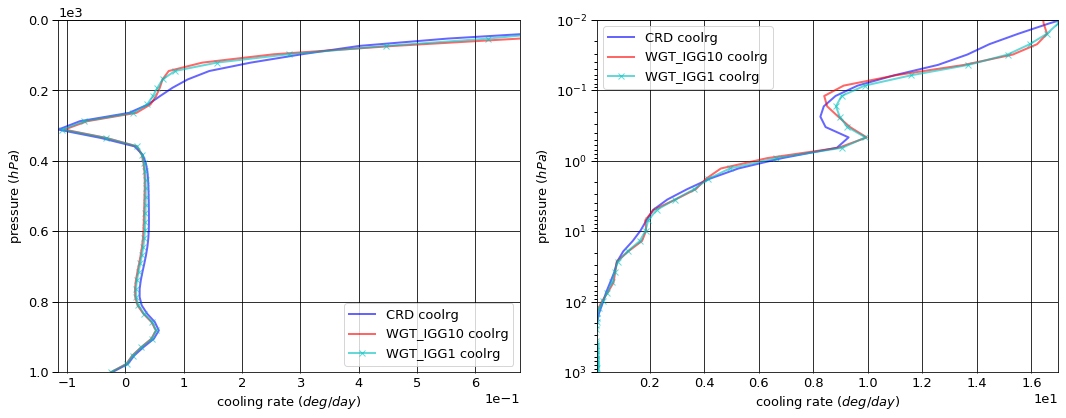

In [23]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [24]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
#table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
#table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.00     1      -0.016857   0.000000 -0.016857
  299.75   46     -0.017722   0.017296 -0.000426
  1013.00  76     -0.034720   0.034906  0.000186
2 0.00     1      -0.089415   0.000000 -0.089415
  299.75   46     -0.058943   0.057528 -0.001415
  1013.00  76     -0.115359   0.115976  0.000617
3 0.00     1      -0.493366   0.000000 -0.493366
  299.75   46     -0.277304   0.270209 -0.007095
  1013.00  76     -0.541847   0.544778  0.002931
4 0.00     1      -1.225397   0.000000 -1.225397
  299.75   46     -0.919380   0.891674 -0.027706
  1013.00  76     -1.789812   1.799595  0.009783
5 0.00     1      -3.328565   0.000000 -3.328565
  299.75   46     -3.392351   3.267808 -0.124543
  1013.00  76     -6.592070   6.628088  0.036017
6 0.00     1      -6.112257   0.000000 -6.112257
  299.75   46     -6.644808   6.306481 -0.338326
  1013.00  76    -12.790834  12.863076  0.072242
7 0.00     1      -2.835994   0.000000 -2.835994
  299.75   46     -3.199193   1.781612 -1.417581
  1013.00  76     -5.172576   5.205960  0.033384


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.00     1      -0.017034   0.000000 -0.017034
  299.75   46     -0.017717   0.017291 -0.000426
  1013.00  76     -0.034724   0.034909  0.000186
2 0.00     1      -0.085846   0.000000 -0.085846
  299.75   46     -0.058873   0.057458 -0.001415
  1013.00  76     -0.115389   0.116006  0.000618
3 0.00     1      -0.512575   0.000000 -0.512575
  299.75   46     -0.276531   0.269883 -0.006648
  1013.00  76     -0.541988   0.544889  0.002901
4 0.00     1      -1.254689   0.000000 -1.254689
  299.75   46     -0.913423   0.891463 -0.021960
  1013.00  76     -1.790269   1.799850  0.009581
5 0.00     1      -3.292159   0.000000 -3.292159
  299.75   46     -3.364114   3.283237 -0.080877
  1013.00  76     -6.593518   6.628805  0.035287
6 0.00     1      -6.033339   0.000000 -6.033339
  299.75   46     -6.531924   6.369043 -0.162881
  1013.00  76    -12.791405  12.859863  0.068458
7 0.00     1      -2.693032   0.000000 -2.693032
  299.75   46     -3.112153   1.903445 -1.208708
  1013.00  76     -5.169926   5.220329  0.050404


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.00     1      -0.017162   0.000000 -0.017162
  299.75   46     -0.017717   0.017291 -0.000426
  1013.00  76     -0.034724   0.034909  0.000186
2 0.00     1      -0.085893   0.000000 -0.085893
  299.75   46     -0.058873   0.057458 -0.001415
  1013.00  76     -0.115389   0.116006  0.000618
3 0.00     1      -0.507541   0.000000 -0.507541
  299.75   46     -0.276531   0.269883 -0.006648
  1013.00  76     -0.541988   0.544889  0.002901
4 0.00     1      -1.255453   0.000000 -1.255453
  299.75   46     -0.913423   0.891463 -0.021960
  1013.00  76     -1.790269   1.799850  0.009581
5 0.00     1      -3.309168   0.000000 -3.309168
  299.75   46     -3.364114   3.283237 -0.080877
  1013.00  76     -6.593518   6.628805  0.035287
6 0.00     1      -6.051296   0.000000 -6.051296
  299.75   46     -6.538274   6.368650 -0.169624
  1013.00  76    -12.791405  12.859888  0.068483
7 0.00     1      -2.735103   0.000000 -2.735103
  299.75   46     -3.143912   1.841552 -1.302360
  1013.00  76     -5.169926   5.222649  0.052723


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.00     1     -0.000178  0.000000 -1.775850e-04
  299.75   46     0.000006 -0.000005  6.029000e-08
  1013.00  76    -0.000004  0.000004  2.117100e-07
2 0.00     1      0.003568  0.000000  3.568147e-03
  299.75   46     0.000070 -0.000070 -9.510000e-08
  1013.00  76    -0.000029  0.000030  6.686200e-07
3 0.00     1     -0.019209  0.000000 -1.920913e-02
  299.75   46     0.000773 -0.000326  4.472851e-04
  1013.00  76    -0.000142  0.000111 -3.082670e-05
4 0.00     1     -0.029292  0.000000 -2.929230e-02
  299.75   46     0.005957 -0.000211  5.746135e-03
  1013.00  76    -0.000457  0.000255 -2.021389e-04
5 0.00     1      0.036407  0.000000  3.640650e-02
  299.75   46     0.028236  0.015429  4.366535e-02
  1013.00  76    -0.001448  0.000718 -7.301630e-04
6 0.00     1      0.078918  0.000000  7.891810e-02
  299.75   46     0.112884  0.062561  1.754450e-01
  1013.00  76    -0.000571 -0.003213 -3.783550e-03
7 0.00     1      0.142962  0.000000  1.429615e-01
  299.75   46     0.087040  0.121833  2.088728e-01
  1013.00  76     0.002650  0.014369  1.701965e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.00     1     -0.000306  0.000000 -3.058120e-04
  299.75   46     0.000006 -0.000005  6.029000e-08
  1013.00  76    -0.000004  0.000004  2.117100e-07
2 0.00     1      0.003522  0.000000  3.521781e-03
  299.75   46     0.000070 -0.000070 -9.510000e-08
  1013.00  76    -0.000029  0.000030  6.686200e-07
3 0.00     1     -0.014176  0.000000 -1.417580e-02
  299.75   46     0.000773 -0.000326  4.472851e-04
  1013.00  76    -0.000142  0.000111 -3.082670e-05
4 0.00     1     -0.030056  0.000000 -3.005620e-02
  299.75   46     0.005957 -0.000211  5.746135e-03
  1013.00  76    -0.000457  0.000255 -2.021389e-04
5 0.00     1      0.019398  0.000000  1.939790e-02
  299.75   46     0.028236  0.015429  4.366535e-02
  1013.00  76    -0.001448  0.000718 -7.301630e-04
6 0.00     1      0.060961  0.000000  6.096140e-02
  299.75   46     0.106534  0.062168  1.687019e-01
  1013.00  76    -0.000571 -0.003188 -3.758887e-03
7 0.00     1      0.100891  0.000000  1.008908e-01
  299.75   46     0.055281  0.059940  1.152205e-01
  1013.00  76     0.002650  0.016689  1.933899e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-14.101850,0.000000,-14.101850
299.75,46,-14.509701,12.592609,-1.917092
1013.00,76,-27.037219,27.192379,0.155160



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-13.888675,0.000000,-13.888675
299.75,46,-14.274735,12.791819,-1.482916
1013.00,76,-27.037219,27.204653,0.167434



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-13.961616,0.000000,-13.961616
299.75,46,-14.312844,12.729533,-1.583311
1013.00,76,-27.037219,27.206997,0.169778



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,2.131752e-01,0.000000,0.213175
299.75,46,2.349663e-01,0.199210,0.434177
1013.00,76,-1.610000e-07,0.012274,0.012274



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,1.402341e-01,0.000000,0.140234
299.75,46,1.968570e-01,0.136924,0.333781
1013.00,76,-1.610000e-07,0.014618,0.014618


In [25]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00128,0.001284
2,0.00425,0.004268
3,0.01996,0.020046
4,0.06595,0.066215
5,0.24303,0.243868
6,0.47273,0.473104
7,0.19280,0.191215


In [26]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.306538e-17
2,6.987267e-19
3,3.736738e-20
4,1.998379e-21
5,1.068718e-22
6,5.714218e-23
7,3.056582e-24


In [27]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [28]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.306538e-17,NaN,0.00128,0.001284,0.00128,0.001284,1.0
2,6.987267e-19,0.053479,0.00425,0.004268,0.00553,0.005552,1.0
3,3.736738e-20,0.053479,0.01996,0.020046,0.02549,0.025598,1.0
4,1.998379e-21,0.053479,0.06595,0.066215,0.09144,0.091813,1.0
5,1.068718e-22,0.053479,0.24303,0.243868,0.33447,0.335681,1.0
6,5.714218e-23,0.534680,0.47273,0.473104,0.80720,0.808785,10.0
7,3.056582e-24,0.053491,0.19280,0.191215,1.00000,1.000000,10.0


In [29]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [30]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
